# Data Processing - TRKR

## Notes on this notebook

In [1]:
# run using dev install of EDA:
# github.com/vsihlab/eda
# commit ID: [TODO, downstream from v0.1.1]

## Imports and global variables

In [13]:
# General imports
import json
import pickle

from IPython.display import display
from lmfit import report_fit
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import eda.analysis.dataframe_plotting as dfplot
import eda.data_io.csv_to_dataframe as csv2df

In [3]:
# GLOBAL UNITS: 
# time: ps
# b-field: mT
# voltages: V

# FIGURE DIMENSIONS FOR PRIVATE USE VS REPO:
# FIG_SIZE_MULT = 4  # normal use
FIG_SIZE_MULT = 2.5  # smaller version for repo notebooks

FONT_SCALE = FIG_SIZE_MULT / 2.5

In [4]:
# Optional: import jtplot to make figures match jupyterthemes config
import importlib
jtplot_found = importlib.util.find_spec("jupyterthemes.jtplot") is not None
if jtplot_found:
    from jupyterthemes import jtplot
    # - currently installed theme will be used to
    jtplot.style(ticks=False, grid=False, fscale=FONT_SCALE)
    # set the default figure size
    jtplot.figsize(x=FIG_SIZE_MULT * 2.5, y=FIG_SIZE_MULT * 2.5)
    # needed to avoid spurious error messages with imshow...
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

## Load data

In [5]:
load_option = 'b'

### Option A: Load already-processed data

In [6]:
if load_option == 'a':
    # REQUIRED: input filepaths
    input_dataframe_filepath = "./processed_dataframe.csv"
    input_metadata_list_filepath = "./processed_metadata_list.json"

    with open(input_dataframe_filepath, 'r') as f:
        full_dataframe = pd.read_csv(f, sep='\t',
                                     index_col=[0, 1, 2])
    with open(input_metadata_list_filepath, 'r') as f:
        file_metadata_list = json.load(f)

    # plot newly created dataframe and show the first few rows
    figure_size = (FIG_SIZE_MULT * 3, FIG_SIZE_MULT * 1.5)
    num_waterfall_plots = 4
    data_column = 'kerr_rotation'
    x_values_column = 'probe_delay'
    y_values_column = None
    xlabel = 'Pump-Probe Delay (ps)'
    ylabel = None
    imshow_kwargs = {'aspect': 1.0,
                     'origin': 'upper'}
    plt.figure(figsize=figure_size)
    ax1 = plt.subplot(1,2,1)
    ax2 = plt.subplot(1,2,2)
    dfplot.plot_dataframe_colorplot(full_dataframe, data_column,
                                    x_values_column, y_values_column,
                                    xlabel=xlabel, ylabel=ylabel,
                                    ax=ax1, **imshow_kwargs)
    dfplot.plot_dataframe_waterfall(full_dataframe, data_column,
                                    num_waterfall_plots,
                                    x_values_column, y_values_column,
                                    xlabel=xlabel, ylabel=None, ax=ax2)
    ax2.yaxis.set_ticklabels([])
    plt.show()
    display(full_dataframe.head(5))

### Option B: Load and process raw data

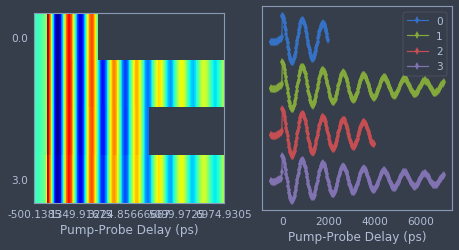

probe_delay   lockin1  kerr_rotation  file_index  \
run_id index_2d index_1d                                                     
0      0.0      0           -500.2216  0.000130       -0.02200           0   
                1           -475.2909  0.000122       -0.02742           0   
                2           -450.3601  0.000088       -0.03182           0   
                3           -425.4294  0.000033       -0.03474           0   
                4           -400.2216  0.000050       -0.03608           0   

                          b_external  wavelength  
run_id index_2d index_1d                          
0      0.0      0              200.0       836.0  
                1              200.0       836.0  
                2              200.0       836.0  
                3              200.0       836.0  
                4              200.0       836.0

In [7]:
if load_option == 'b':
    # REQUIRED: output filenames
    output_dataframe_filename = "processed_dataframe.csv"
    output_metadata_list_filename = "processed_metadata_list.json"
    output_image_filename = "processed_dataframe_plot.png"

    # REQUIRED: data directory
    parent_dir = ('.')

    # REQUIRED: data storage format information
    delimiter = '\t'
    trailing_delimiters = True  # rows end in delimiters
    num_headerlines = 0
    column_names_row = 1  # NOT counting skipped lines from num_headerlines
    overwriting_column_names = []

    if not overwriting_column_names:
        overwriting_column_names = None
    pandas_read_csv_kwargs = {
         'skiprows': num_headerlines,
         'header': column_names_row,
         'names': overwriting_column_names,
         'delimiter': delimiter,
    }
    if trailing_delimiters:  # needed to avoid problems
        pandas_read_csv_kwargs['index_col'] = False

    # REQUIRED: filename key for data files, will load only these
    filename_key = '.dat'

    # REQUIRED: criteria for grouping runs
    run_criteria = 'directory'

    # OPTIONAL: filepath parsing rules
    # DEFAULT SEARCH TERMS AND SEARCH RULES:
    # 1. If first string found, register second string as
    #    tag containing third string/value
    #        e.g. if keyword_list contains ("warmup", "Warmup?", "Yes"):
    #             "...warmup..." -> {"Warmup?": "Yes"}
    this_element_keyword_list = [
        (       "CISP", "Experiment Type", "CISP"       ),
        ( "Delay_Scan", "Experiment Type", "Delay_Scan" ),
        ( "Field_Scan", "Experiment Type", "Field_Scan" ),
        ("Mirror_Scan", "Experiment Type", "Mirror_Scan"),
        ( "RMBE1130-K", "Sample ID", "RMBE1130-K"),
        ("[1-10]Horiz", "Sample Orientation", "[1-10]Horiz"),
    ]
    # 2. Grab next element(s) if this one CONTAINS first string,
    #    tag next element(s) as second string(s)
    #        e.g. "..._Ind_3_..." -> {"FastScanIndex": 3}
    #        e.g. "..._2Dscan_MirrorY_MirrorZ_..."
    #                 -> {"SecondScanType": "MirrorY",
    #                     "FirstScanType": "MirrorZ"}
    next_element_keyword_list = []
    # 3. Grab this element if it CONTAINS first string,
    #    tag remainder as second string
    #        e.g. "..._30K_..." -> {"SetTemperature": 30}
    in_this_element_keyword_list = [
        ("FIELD", "Date_and_Scan_2D_Index"),
        ("DLAY", "Date_and_Scan_2D_Index"),
        ("STPR", "Date_and_Scan_2D_Index"),
        ("phi-", "Electric Field Angle"),
        ("T", "Magnetic Field (T)"),
        ("K", "Set Temperature (K)"),
        ("nm", "Wavelength (nm)"),
        ("ps", "Delay Time (ps)"),
        ("V", "Voltage (V)"),
    ]
    parsing_keyword_lists = [this_element_keyword_list,
                             next_element_keyword_list,
                             in_this_element_keyword_list]

    # OPTIONAL: metadata processing functions,
    # must accept dict and modify in-place
    def derive_metadata_from_scan_type_tag(metadata_dict):
        if 'Date_and_Scan_2D_Index' in metadata_dict.keys():
            date_and_index = str(metadata_dict['Date_and_Scan_2D_Index'])
            metadata_dict['Date'] = date_and_index[:6]
            metadata_dict['Scan_2D_Index'] = float(date_and_index[6:]) - 1
            del metadata_dict['Date_and_Scan_2D_Index']
    def consolidate_aliases_for_bfield(metadata_dict):
        if 'Magnetic Field (T)' in metadata_dict.keys():
            metadata_dict['Magnetic Field (mT)'] = \
                1000.0 * metadata_dict['Magnetic Field (T)']
    metadata_processing_fcns = [derive_metadata_from_scan_type_tag,
                                consolidate_aliases_for_bfield]

    # OPTIONAL: metadata-based filtering fcns, type: dict() -> bool
    # fcns returning False if data should be ignored
    metadata_filter_fcns = [
        lambda metadata_dict: \
            "alignment" not in metadata_dict.get("Filepath"),
    #     lambda metadata_dict: \
    #         metadata_dict.get("# repeats", 1) <= 2,
        lambda metadata_dict: \
            "Scan_2D_Index" in metadata_dict.keys(),
    ]

    # OPTIONAL: metadata tags to be converted to dataframe columns.
    # Elements should be of form ('metadata tag', 'column name')
    metadata_tag_to_column_list = [
        (             'Run ID', 'run_id'),
        (      'Scan_2D_Index', 'index_2d'),
        ('Magnetic Field (mT)', 'b_external'),
        (    'Wavelength (nm)', 'wavelength'),
    ]

    # OPTIONAL: dataframe processing functions,
    # must accept dataframe and modify in-place
    def set_dataframe_indices(df):
        df['index_1d'] = df.index  # assumes index = 0,1,2,...  
        df.set_index(['run_id', 'index_2d', 'index_1d'],
                     drop=True, append=False, inplace=True)
    def edit_dataframe_colnames(df):
        renaming_dict = {'Delay (ps)': 'probe_delay',
                         'Lock-In 1 (V)': 'lockin1',
                         'Lock-In 2 (V)': 'kerr_rotation'}
        filtered_renaming_dict = \
            {key: val
             for (key, val) in renaming_dict.items()
             if key in list(df)}
        df.rename(columns=filtered_renaming_dict, inplace=True)
    dataframe_processing_fcns = [
        set_dataframe_indices,
        edit_dataframe_colnames,
    ]

    file_dataframes_list, file_metadata_list = \
        csv2df.process_directory_csvs_to_dataframes(
            parent_dir, filename_key, run_criteria,
            pandas_read_csv_kwargs,
            parsing_keyword_lists,
            metadata_processing_fcns,
            metadata_filter_fcns,
            metadata_tag_to_column_list,
            dataframe_processing_fcns)

    full_dataframe = pd.concat(file_dataframes_list)
    full_dataframe.sort_index(ascending=True, inplace=True)

    # Save processed dataframe & metadata to file
    with open(output_dataframe_filename, 'w') as f:
        full_dataframe.to_csv(f, sep='\t')
    with open(output_metadata_list_filename, 'w') as f:
        json.dump(file_metadata_list, f)

    # plot newly created dataframe and show the first few rows
    figure_size = (FIG_SIZE_MULT * 3, FIG_SIZE_MULT * 1.5)
    num_waterfall_plots = 4
    data_column = 'kerr_rotation'
    x_values_column = 'probe_delay'
    y_values_column = None
    xlabel = 'Pump-Probe Delay (ps)'
    ylabel = None
    imshow_kwargs = {'aspect': 1.0,
                     'origin': 'upper'}
    plt.figure(figsize=figure_size)
    ax1 = plt.subplot(1,2,1)
    ax2 = plt.subplot(1,2,2)
    dfplot.plot_dataframe_colorplot(full_dataframe, data_column,
                                    x_values_column, y_values_column,
                                    xlabel=xlabel, ylabel=ylabel,
                                    ax=ax1, **imshow_kwargs)
    dfplot.plot_dataframe_waterfall(full_dataframe, data_column,
                                    num_waterfall_plots,
                                    x_values_column, y_values_column,
                                    xlabel=xlabel, ylabel=None, ax=ax2)
    ax2.yaxis.set_ticklabels([])
    plt.savefig(output_image_filename,
                bbox_inches='tight',
                transparent=False)
    plt.show()
    display(full_dataframe.head(5))

In [8]:
# TAKE A LOOK AT ANY SUBFILE
file_index = 0
for key, val in file_metadata_list[file_index].items():
    print("{}: {}".format(key, val))
file_dataframes_list[file_index].head()

Sample Orientation: [1-10]Horiz
Filepath: .\170606DLAY01 Delay_Scan RMBE1130-K_30K_836nm_[1-10]Horiz_0.2T.dat
Run ID: 0
Wavelength (nm): 836.0
File Last Modified: Mon Jul 24 11:17:15 2017
Scan_2D_Index: 0.0
Sample ID: RMBE1130-K
Date: 170606
Set Temperature (K): 30.0
Magnetic Field (mT): 200.0
Magnetic Field (T): 0.2


probe_delay   lockin1  kerr_rotation  file_index  \
run_id index_2d index_1d                                                     
0      0.0      0           -500.2216  0.000130       -0.02200           0   
                1           -475.2909  0.000122       -0.02742           0   
                2           -450.3601  0.000088       -0.03182           0   
                3           -425.4294  0.000033       -0.03474           0   
                4           -400.2216  0.000050       -0.03608           0   

                          b_external  wavelength  
run_id index_2d index_1d                          
0      0.0      0              200.0       836.0  
                1              200.0       836.0  
                2              200.0       836.0  
                3              200.0       836.0  
                4              200.0       836.0

In [9]:
# # EXAMPLE - REORDERING AXES
# df = full_dataframe
# df = df.groupby(level=[-3, -2]).head(5)
# new_index = df.index.reorder_levels([-2, -3, -1])
# df.index = new_index
# df.head()

## Dataset fit model and residuals

In [10]:
# GLOBAL CONSTANTS
GFACTORCONSTANT = 1.3996e-5  # 1/(ps*mTesla), = bohr magneton/2*pi*hbar
LASER_REPRATE = 13158  # ps period

from eda.analysis.fit_tools import create_residuals_fcn
from eda.models.simple_dnp_trkr_rsa_simulation \
    import trkr_decaying_cosine

trkr_decaying_cosine_residuals = \
    create_residuals_fcn(trkr_decaying_cosine,
                         ['delay_time', 'total_bfield'])

## Dataset fit parameter setup and constraints

In [11]:
from lmfit import Parameters

params_guesses = [('pulse_amplitude',     {'value' : 1e-3,
                                           'min'   : 0.0,
                                           'max'   : 1.0}),
                  ('gfactor',             {'value' : 0.40,
                                           'min'   : 0.35,
                                           'max'   : 0.50,
                                           'vary'  : True}),
                  ('spin_lifetime',       {'value' : 2000.0,
                                           'min'   : 0.0,
                                           'max'   : 1e5}),
                  ('initial_phase',       {'value' : 0.0,
                                           'vary'  : False}),
                  ('extra_phase_offset',  {'value' : 0.0,
                                           'min'   : -np.pi,
                                           'max'   : +np.pi}),
                  ('slope',               {'value' : 0.0,
                                           'min'   : -1e-2,
                                           'max'   : +1e-2}),
                  ('offset',              {'value' : 0.0,
                                           'min'   : -1e-2,
                                           'max'   : +1e-2}),
                 ]
fit_params = Parameters()
for param_name, param_guess_dict in params_guesses:
    fit_params.add(param_name, **param_guess_dict)

## Fit all datasets (1D)

file_index  b_external  wavelength  pulse_amplitude  \
run_id index_2d                                                        
0.0    0.0              0.0       200.0      836.00         0.386819   
       1.0              1.0       200.0      836.00         0.410003   
       2.0              2.0       200.0      836.00         0.408352   
       3.0              3.0       200.0      836.17         0.392691   

                 pulse_amplitude_error   gfactor  gfactor_error  \
run_id index_2d                                                   
0.0    0.0                    0.008851  0.405162       0.000924   
       1.0                    0.005446  0.404725       0.000278   
       2.0                    0.001084  0.404369       0.000084   
       3.0                    0.005408  0.405171       0.000289   

                 spin_lifetime  spin_lifetime_error  initial_phase  \
run_id index_2d                                                      
0.0    0.0         7517.226139           857.867390            0.0   
       1.0         4945.875900           120.927935            0.0   
       2.0         5039.222647            35.580412            0.0   
       3.0         4934.963889           124.821427            0.0   

                 extra_phase_offset  extra_phase_offset_error         slope  \
run_id index_2d                                                               
0.0    0.0                 0.059266                  0.025113 -8.937828e-06   
       1.0                 0.063383                  0.013178 -7.896465e-07   
       2.0                 0.064599                  0.002788 -1.221752e-07   
       3.0                 0.070988                  0.013674 -7.553231e-07   

                  slope_error    offset  offset_error  result_index    chisqr  \
run_id index_2d                                                                 
0.0    0.0       6.912700e-06  0.010000      0.007360             0  0.135051   
       1.0       6.317701e-07  0.006159      0.002477             1  0.162882   
       2.0       2.570474e-07  0.001602      0.000560             2  0.003116   
       3.0       6.272968e-07  0.006618      0.002459             3  0.160486   

                   redchi  
run_id index_2d            
0.0    0.0       0.001437  
       1.0       0.000554  
       2.0       0.000018  
       3.0       0.000546

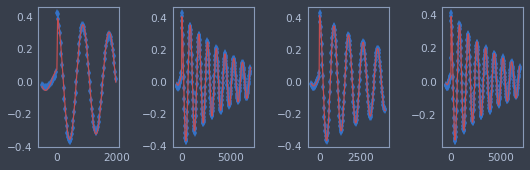

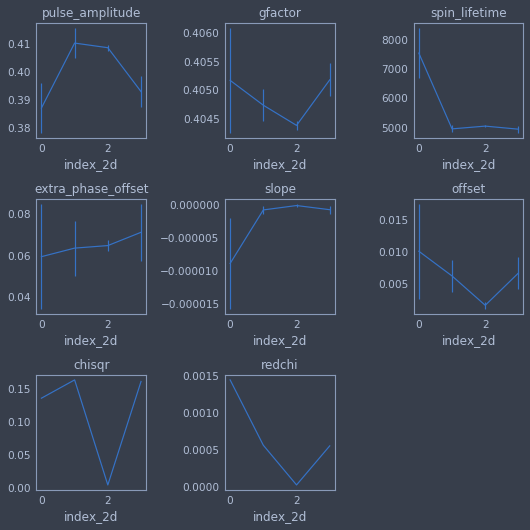

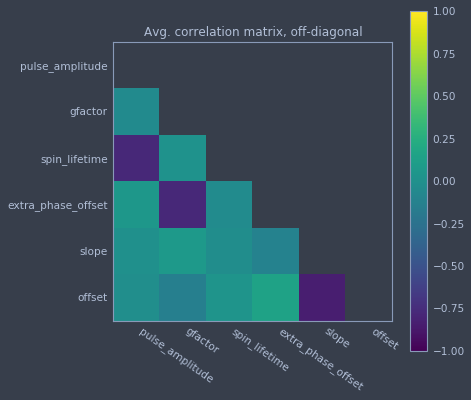

In [12]:
from eda.analysis.dataframe_processing \
    import df_minimize_fcn_on_datasets

df = full_dataframe
residuals_fcn = trkr_decaying_cosine_residuals
fit_params = fit_params
independent_vars_columns = ["probe_delay", "b_external"]
measured_data_column = "kerr_rotation"
column_aggregation_dict = {}  # needed to keep cols w/ non-const values
keep_const_columns = True

output_fit_results_dataframe_filename = "fit_results_dataframe.csv"
output_fit_minimize_results_filename = "fit_minimize_results.pickle"
output_fit_vs_data_image_filename = "fit_results_fit_vs_data.png"
output_fit_params_image_filename = "fit_results_fit_params.png"
output_fit_covariances_image_filename = "fit_results_covariances.png"

# Fit!
minimize_results, results_df = \
    df_minimize_fcn_on_datasets(
        df, residuals_fcn, fit_params,
        independent_vars_columns,
        measured_data_column,
        column_aggregation_dict=column_aggregation_dict,  # keywords only!
#        method='nelder',
        keep_const_columns=keep_const_columns,
    )

# add minimizer result attributes to results_df
attributes_to_add = ['chisqr', 'redchi']
for attribute in attributes_to_add:
    attribute_list = []
    for result in minimize_results:
        attribute_list.append(getattr(result, attribute))
    results_df[attribute] = attribute_list

# Display fit params dataframe & save to file
with open(output_fit_results_dataframe_filename, 'w') as f:
    results_df.to_csv(f, sep='\t')
with open(output_fit_minimize_results_filename, 'wb') as f:
    pickle.dump(minimize_results, f)
display(results_df.head(5))

# plot fits
scan_coord_1d_column = 'probe_delay'
ncols = 4
nplots = len(minimize_results)
nrows = np.int(np.ceil(nplots / ncols))
plt.figure(figsize=(FIG_SIZE_MULT * 3, FIG_SIZE_MULT * nrows))
for result_index in list(range(nplots)):
    ax = plt.subplot(nrows, ncols, result_index + 1)
    result = minimize_results[result_index]
    dataset_index = results_df.index[result_index]
    xvals = df.loc[dataset_index][scan_coord_1d_column]
    yvals = df.loc[dataset_index][measured_data_column]
    fit_yvals = residuals_fcn(result.params,
                              df.loc[dataset_index].probe_delay,
                              df.loc[dataset_index].b_external)
    ax.plot(xvals, yvals, 'bd', label='dataset {}'.format(result_index))
    ax.plot(xvals, fit_yvals, 'r')
    plt.tight_layout()
plt.savefig(output_fit_vs_data_image_filename,
            bbox_inches='tight',
            transparent=False)

# plot params
params_to_plot_list = result.var_names + attributes_to_add
ncols = 3
nplots = len(params_to_plot_list)
nrows = np.int(np.ceil(nplots / ncols))
plt.figure(figsize=(FIG_SIZE_MULT * 3, FIG_SIZE_MULT * nrows))
for ind, param in enumerate(params_to_plot_list):
    ax = plt.subplot(nrows, ncols, ind + 1)
    if (param + '_error') in list(results_df):
        ax.errorbar(x=results_df.index.get_level_values(-1),
                    y=results_df[param],
                    yerr=results_df[param + '_error'])
    else:
        ax.plot(results_df.index.get_level_values(-1),
                results_df[param].values)
    plt.xlabel(results_df.index.names[-1])
    plt.tight_layout()
    plt.title(param)
plt.savefig(output_fit_params_image_filename,
            bbox_inches='tight',
            transparent=False)

# Plot the avg. covariance matrix
corr_mats = []
for result in minimize_results:
    covar = result.covar
    oostd = np.diagflat([1.0 / param.stderr
                         for param in list(result.params.values())
                         if param.name in result.var_names])
    corr = np.dot(np.dot(oostd, result.covar), oostd)
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    corr[mask] = np.nan
    corr_mats.append(corr)
avgcorr = np.mean(corr_mats, axis=0)
plt.figure()
plt.imshow(corr, vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(np.arange(result.nvarys), result.var_names,
           rotation=-35, ha='left')
plt.yticks(np.arange(result.nvarys), result.var_names)
plt.title('Avg. correlation matrix, off-diagonal')
plt.savefig(output_fit_covariances_image_filename,
            bbox_inches='tight',
            transparent=False)
plt.show()


----------------------------------------


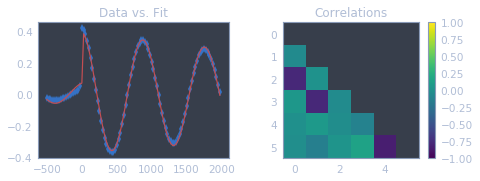

FIT #1
run_id: 0.0
index_2d: 0.0
[[Fit Statistics]]
    # function evals   = 159
    # data points      = 100
    # variables        = 6
    chi-square         = 0.135
    reduced chi-square = 0.001
    Akaike info crit   = -648.727
    Bayesian info crit = -633.096
[[Variables]]
    pulse_amplitude:      0.38681919 +/- 0.008851 (2.29%) (init= 0.001)
    gfactor:              0.40516241 +/- 0.000924 (0.23%) (init= 0.4)
    spin_lifetime:        7517.22613 +/- 857.8673 (11.41%) (init= 2000)
    initial_phase:        0 (fixed)
    extra_phase_offset:   0.05926567 +/- 0.025112 (42.37%) (init= 0)
    slope:               -8.9378e-06 +/- 6.91e-06 (77.34%) (init= 0)
    offset:               0.00999998 +/- 0.007359 (73.60%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(slope, offset)             = -0.835 
    C(gfactor, extra_phase_offset)  = -0.714 
    C(pulse_amplitude, spin_lifetime)  = -0.609 
    C(gfactor, offset)           = -0.587 
    C(spin_lifetime, slop

None

----------------------------------------


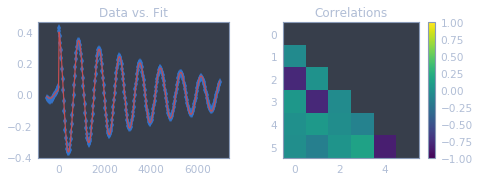

FIT #2
run_id: 0.0
index_2d: 1.0
[[Fit Statistics]]
    # function evals   = 120
    # data points      = 300
    # variables        = 6
    chi-square         = 0.163
    reduced chi-square = 0.001
    Akaike info crit   = -2243.554
    Bayesian info crit = -2221.332
[[Variables]]
    pulse_amplitude:      0.41000266 +/- 0.005445 (1.33%) (init= 0.001)
    gfactor:              0.40472450 +/- 0.000278 (0.07%) (init= 0.4)
    spin_lifetime:        4945.87590 +/- 120.9279 (2.45%) (init= 2000)
    initial_phase:        0 (fixed)
    extra_phase_offset:   0.06338263 +/- 0.013177 (20.79%) (init= 0)
    slope:               -7.8965e-07 +/- 6.32e-07 (80.01%) (init= 0)
    offset:               0.00615947 +/- 0.002476 (40.21%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(slope, offset)             = -0.833 
    C(pulse_amplitude, spin_lifetime)  = -0.769 
    C(gfactor, extra_phase_offset)  = -0.768 
    C(extra_phase_offset, offset)  =  0.152 
    C(gfactor, offset)

None

----------------------------------------


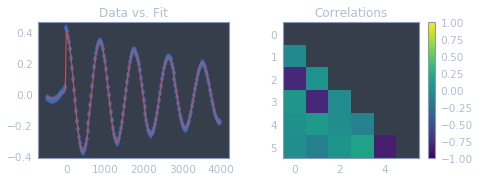

FIT #3
run_id: 0.0
index_2d: 2.0
[[Fit Statistics]]
    # function evals   = 81
    # data points      = 180
    # variables        = 6
    chi-square         = 0.003
    reduced chi-square = 0.000
    Akaike info crit   = -1961.549
    Bayesian info crit = -1942.392
[[Variables]]
    pulse_amplitude:      0.40835162 +/- 0.001083 (0.27%) (init= 0.001)
    gfactor:              0.40436944 +/- 8.44e-05 (0.02%) (init= 0.4)
    spin_lifetime:        5039.22264 +/- 35.58041 (0.71%) (init= 2000)
    initial_phase:        0 (fixed)
    extra_phase_offset:   0.06459941 +/- 0.002787 (4.32%) (init= 0)
    slope:               -1.2218e-07 +/- 2.57e-07 (210.39%) (init= 0)
    offset:               0.00160157 +/- 0.000559 (34.96%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(slope, offset)             = -0.822 
    C(gfactor, extra_phase_offset)  = -0.807 
    C(pulse_amplitude, spin_lifetime)  = -0.789 
    C(gfactor, slope)            =  0.305 
    C(gfactor, offset)   

None

----------------------------------------


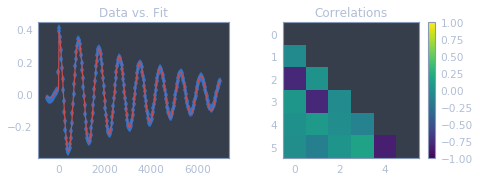

FIT #4
run_id: 0.0
index_2d: 3.0
[[Fit Statistics]]
    # function evals   = 135
    # data points      = 300
    # variables        = 6
    chi-square         = 0.160
    reduced chi-square = 0.001
    Akaike info crit   = -2248.000
    Bayesian info crit = -2225.777
[[Variables]]
    pulse_amplitude:      0.39269075 +/- 0.005408 (1.38%) (init= 0.001)
    gfactor:              0.40517145 +/- 0.000289 (0.07%) (init= 0.4)
    spin_lifetime:        4934.96388 +/- 124.8214 (2.53%) (init= 2000)
    initial_phase:        0 (fixed)
    extra_phase_offset:   0.07098844 +/- 0.013673 (19.26%) (init= 0)
    slope:               -7.5532e-07 +/- 6.27e-07 (83.05%) (init= 0)
    offset:               0.00661752 +/- 0.002459 (37.16%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(slope, offset)             = -0.833 
    C(pulse_amplitude, spin_lifetime)  = -0.769 
    C(gfactor, extra_phase_offset)  = -0.769 
    C(extra_phase_offset, offset)  =  0.155 
    C(gfactor, offset)

None

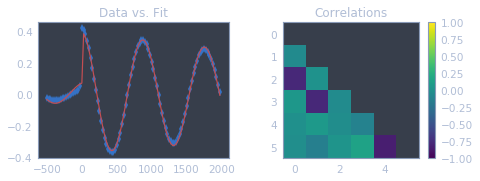

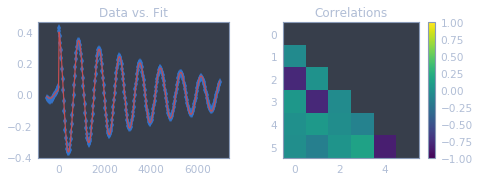

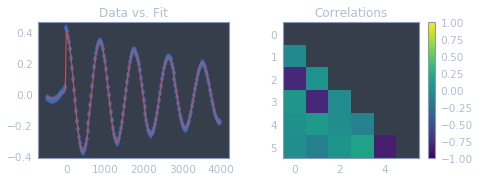

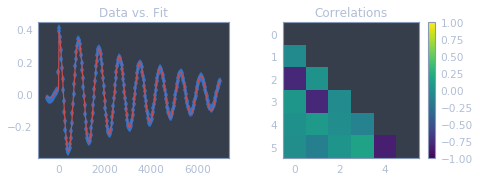

In [56]:
# DETAILED FIT REPORTS
for result_index, result in enumerate(minimize_results):
    print('----------------------------------------')
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False,
                                   figsize=(FIG_SIZE_MULT * 3,
                                            FIG_SIZE_MULT * 1))
    dataset_index = results_df.index[result_index]
    xvals = df.loc[dataset_index][scan_coord_1d_column]
    yvals = df.loc[dataset_index][measured_data_column]
    fit_yvals = residuals_fcn(result.params,
                              df.loc[dataset_index].probe_delay,
                              df.loc[dataset_index].b_external)
    ax1.plot(xvals, yvals, 'bd', label='dataset {}'.format(result_index))
    ax1.plot(xvals, fit_yvals, 'r')
    ax1.set_title('Data vs. Fit')
    img = ax2.imshow(corr, vmin=-1, vmax=1)
    fig.colorbar(img, ax=ax2)
    ax2.set_title('Correlations')
    display(fig)
    print('FIT #{}'.format(result_index + 1))
    for col, val in zip(results_df.index.names,
                        results_df.index[result_index]):
        print('{}: {}'.format(col, val))
    display(report_fit(result))